In [20]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import numpy as np

from PIL import Image
import os
import random
import torch.optim as optim

from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from art_generator.config import PROCESSED_DATA_DIR

In [21]:
def get_random_image(dataset):
    random_index = np.random.randint(len(dataset))
    image, label = dataset[random_index]
    return image, label

In [22]:
def get_random_image_sizes(directory, num_images=2):
    # Get all image files in the directory
    image_files = [f for f in os.listdir(directory) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]
    
    # Randomly select images
    selected_images = random.sample(image_files, min(num_images, len(image_files)))
    
    # Get and print sizes
    for image_file in selected_images:
        image_path = os.path.join(directory, image_file)
        with Image.open(image_path) as img:
            print(f"{image_file}: {img.size}")

In [23]:
directory_path = PROCESSED_DATA_DIR / 'monet_jpg'
get_random_image_sizes(directory_path)

fb806a2a1c.jpg: (256, 256)
d5b0c260a0.jpg: (256, 256)


In [24]:
image_size = 256

dataset = ImageFolder(root=PROCESSED_DATA_DIR, 
                      transform=transforms.Compose([transforms.Resize(image_size),
                                                    transforms.CenterCrop(image_size),
                                                    transforms.ToTensor(),
                                                    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
                                                    ]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


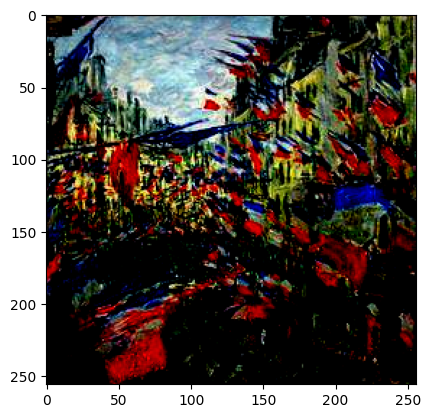

In [25]:
image, label = get_random_image(dataset)
plt.imshow(image.permute(1,2,0))

In [26]:
batch_size = 128
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
device = "cuda" if torch.cuda.is_available() else "cpu"

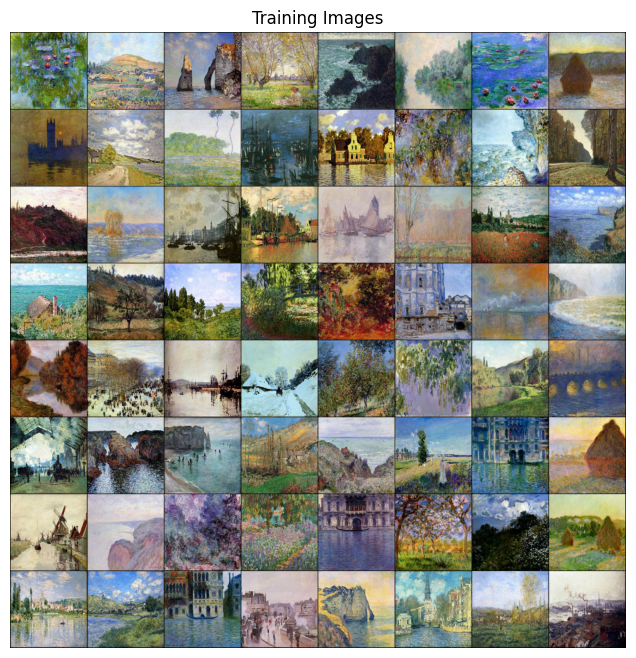

In [27]:
# Plot some training images
import torchvision.utils as vutils

real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [28]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [29]:
# Generator Code
nz = 100
ngf = 64
nc = 3

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 32, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 32),
            nn.ReLU(True),
            # state size. ``(ngf*32) x 4 x 4``
            nn.ConvTranspose2d(ngf * 32, ngf * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
            # state size. ``(ngf*16) x 8 x 8``
            nn.ConvTranspose2d( ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 16 x 16``
            nn.ConvTranspose2d( ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 32 x 32``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 64 x 64``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 128 x 128
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 256 x 256
        )

    def forward(self, input):
        return self.main(input)

In [30]:
# Create the generator
ngpu = 1
netG = Generator(ngpu).to(device)
netG.apply(weights_init)
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 2048, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Ba

In [31]:
ndf = 64

class Critic(nn.Module):
    def __init__(self, ngpu):
        super(Critic, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 256 x 256
            nn.Conv2d(nc, ndf, 4, stride=2, padding=1, bias=True),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 128 x 128
            nn.Conv2d(ndf, ndf * 2, 4, stride=2, padding=1, bias=True),
            nn.InstanceNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 64 x 64
            nn.Conv2d(ndf * 2, ndf * 4, 4, stride=2, padding=1, bias=True),
            nn.InstanceNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 32 x 32
            nn.Conv2d(ndf * 4, ndf * 8, 4, stride=2, padding=1, bias=True),
            nn.InstanceNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 16 x 16
            nn.Conv2d(ndf * 8, ndf * 16, 4, stride=2, padding=1, bias=True),
            nn.InstanceNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*16) x 8 x 8
            nn.Conv2d(ndf * 16, ndf * 32, 4, stride=2, padding=1, bias=True),
            nn.InstanceNorm2d(ndf * 32),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*32) x 4 x 4
            nn.Conv2d(ndf * 32, 1, 4, stride=1, padding=0, bias=True),
            # output size. 1 x 1 x 1
        )

    def forward(self, input):
        return self.main(input).view(-1)

In [32]:
# import torch
# import torch.nn as nn
# 
# class Discriminator(nn.Module):
#     def __init__(self, ngpu):
#         super(Discriminator, self).__init__()
#         self.ngpu = ngpu
#         self.layers = nn.ModuleList([
#             # input is (nc) x 256 x 256
#             nn.Conv2d(nc, ndf, 4, stride=2, padding=1, bias=False),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf) x 128 x 128
#             nn.Conv2d(ndf, ndf * 2, 4, stride=2, padding=1, bias=False),
#             nn.BatchNorm2d(ndf * 2),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf*2) x 64 x 64
#             nn.Conv2d(ndf * 2, ndf * 4, 4, stride=2, padding=1, bias=False),
#             nn.BatchNorm2d(ndf * 4),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf*4) x 32 x 32
#             nn.Conv2d(ndf * 4, ndf * 8, 4, stride=2, padding=1, bias=False),
#             nn.BatchNorm2d(ndf * 8),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf*8) x 16 x 16
#             nn.Conv2d(ndf * 8, ndf * 16, 4, stride=2, padding=1, bias=False),
#             nn.BatchNorm2d(ndf * 16),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf*16) x 8 x 8
#             nn.Conv2d(ndf * 16, ndf * 32, 4, stride=2, padding=1, bias=False),
#             nn.BatchNorm2d(ndf * 32),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf*32) x 4 x 4
#             nn.Conv2d(ndf * 32, 1, 4, stride=1, padding=0, bias=False),
#             nn.Sigmoid()
#             # output size. 1 x 1 x 1
#         ])
# 
#     def forward(self, input):
#         x = input
#         print(f"Input shape: {x.shape}")
#         for i, layer in enumerate(self.layers):
#             x = layer(x)
#             print(f"After layer {i} ({layer.__class__.__name__}): {x.shape}")
#         return x.view(-1, 1).squeeze(1)
# 
# # Test the Discriminator
# def test_discriminator():
#     # Set random seed for reproducibility
#     torch.manual_seed(999)
# 
#     # Hyperparameters
#     ngpu = 1
#     nc = 3  # Number of channels in the training images. For color images this is 3
#     ndf = 64  # Size of feature maps in discriminator
# 
#     # Create the Discriminator
#     netD = Discriminator(ngpu)
# 
#     # Create a sample input
#     batch_size = 128
#     sample_input = data[0]
#     # sample_input = torch.randn(batch_size, nc, 64, 64)
# 
#     # Run the sample input through the discriminator
#     print("Running sample input through the discriminator:")
#     output = netD(sample_input)
# 
#     print(f"\nFinal output shape: {output.shape}")
# 
# # Run the test
# test_discriminator()

In [33]:
# # Test the Discriminator
# def test_discriminator():
#     # Set random seed for reproducibility
#     torch.manual_seed(999)
# 
#     # Hyperparameters
#     ngpu = 1
#     nc = 3  # Number of channels in the training images. For color images this is 3
#     ndf = 64  # Size of feature maps in discriminator
# 
#     # Create the Discriminator
#     netD = Discriminator(ngpu, nc, ndf)
# 
#     # Create a sample input
#     batch_size = 128
#     # sample_input = data[0]
#     sample_input = torch.randn(batch_size, nc, 64, 64)
# 
#     # Run the sample input through the discriminator
#     print("Running sample input through the discriminator:")
#     output = netD(sample_input)
# 
#     print(f"\nFinal output shape: {output.shape}")
# 
# # Run the test
# test_discriminator()

In [34]:
netC = Critic(ngpu).to(device)
netC.apply(weights_init)
print(netC)

Critic(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (12): InstanceNorm2d(1024, eps=1e-05, momentum=0.1, affine=False, track_running_stats

In [35]:
# Gradient penalty function
def compute_gradient_penalty(critic, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN-GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=device)
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    critic_interpolates = critic(interpolates)
    fake = torch.ones(real_samples.size(0), 1, device=device, requires_grad=False)
    # Get gradient w.r.t. interpolates
    gradients = torch.autograd.grad(
        outputs=critic_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

# Wasserstein loss
def wasserstein_loss(y_pred, y_true):
    return torch.mean(y_true * y_pred)

fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Hyperparameters
lr = 5e-5
beta1 = 0.5
n_critic = 5  # Number of critic iterations per generator iteration
lambda_gp = 10  # Gradient penalty lambda hyperparameter

# Setup RMSProp optimizers for both G and C
optimizerD = optim.RMSprop(netC.parameters(), lr=lr)
optimizerG = optim.RMSprop(netG.parameters(), lr=lr)

In [37]:
# Training Loop
num_epochs = 100
n_critic = 5  # number of critic iterations per generator iteration
lambda_gp = 10  # Gradient penalty lambda hyperparameter

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")

# Gradient penalty function
def compute_gradient_penalty(critic, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN-GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=device)
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    critic_interpolates = critic(interpolates)
    # Create a tensor of ones with the same shape as critic_interpolates
    fake = torch.ones(critic_interpolates.size(), device=device, requires_grad=False)
    # Get gradient w.r.t. interpolates
    gradients = torch.autograd.grad(
        outputs=critic_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        
        ############################
        # (1) Update D network
        ###########################
        for _ in range(n_critic):
            netC.zero_grad()
            
            # Train with real
            real_images = data[0].to(device)
            b_size = real_images.size(0)
            
            # Train with fake
            noise = torch.randn(b_size, nz, 1, 1, device=device)
            fake = netG(noise)
            
            # Critic loss
            real_validity = netC(real_images).view(-1)
            fake_validity = netC(fake.detach()).view(-1)
            
            # Gradient penalty
            gradient_penalty = compute_gradient_penalty(netC, real_images.data, fake.data)
            
            # Wasserstein loss
            d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty
            
            d_loss.backward()
            optimizerD.step()

        ############################
        # (2) Update G network
        ###########################
        netG.zero_grad()
        
        # Generate fake images
        fake = netG(noise)
        # Loss measures generator's ability to fool the discriminator
        fake_validity = netC(fake).view(-1)
        g_loss = -torch.mean(fake_validity)
        
        g_loss.backward()
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     d_loss.item(), g_loss.item()))

        # Save Losses for plotting later
        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/100][0/3]	Loss_D: 119.7950	Loss_G: 12.9284
[1/100][0/3]	Loss_D: -15.2538	Loss_G: 34.3635


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()